In [2]:
#import pyactup as pau
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from scipy.optimize import minimize
import seaborn as sns

import random
import math
from math import log
from math import exp
from pybads import BADS
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.ticker import FixedFormatter
sns.set_style("whitegrid")

# Cepeda's Data

Cepeda et al's (2008) is perhaps the most extensive examination of the spacing effect. In Cepeda's data, participants were asked to study trivia questions and answers ("Which country consumes more hot sauce? Norway"). Each question was studied twice, at times $t_1$ and $t_2$ and tested once, at time $t_3$. The space between $t_1$ and $t_2$ is the _spacing_, while the space between $t_2$ and $t_3$ is the _Retention Interval_ (RI). 

In [3]:
cepeda = pd.read_csv("cepeda_recall.csv")
cepeda

,RI,Spacing,Accuracy
0,35,0.00256,0.522955
1,35,1.00000,0.690765
2,35,4.00000,0.738259
3,35,7.00000,0.804749
4,35,11.00000,0.822164
5,35,21.00000,0.758839
6,35,105.00000,0.598945
7,7,0.00256,0.887071
8,7,1.00000,0.978892
9,7,2.00000,0.956728


Here is a visualization of the data

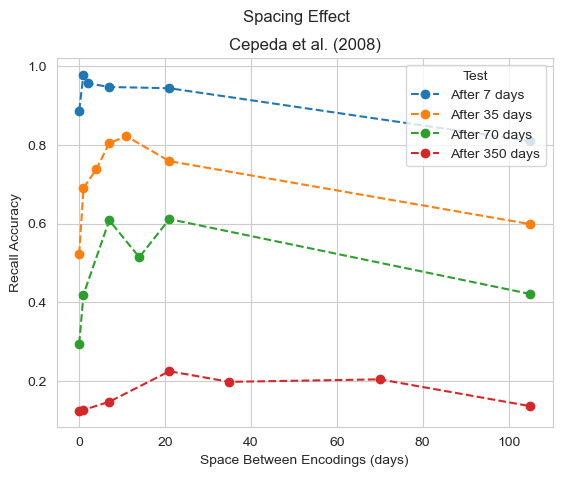

In [4]:
fig, ax = plt.subplots()
cepeda.groupby("RI").plot(x="Spacing", y="Accuracy", marker="o", ax=ax, linestyle="--")
ax.legend(["After %d days" % (x,) for x in [7, 35, 70, 350]], loc="upper right", title="Test")
ax.set_ylabel("Recall Accuracy")
ax.set_xlabel("Space Between Encodings (days)")
ax.set_title("Cepeda et al. (2008)")
fig.suptitle("Spacing Effect")
plt.show()

To compare the different models, we will encode the design of Cepeda's experiment in a dictionary object.

In [5]:
# Cepeda's experiment design
design = {7 : [0.00256, 1, 2, 7, 21, 105],
          35 : [0.00256, 1, 4, 7, 11, 21, 105],
          70 : [0.00256, 1, 7, 14, 21, 105],
          350 : [0.00256, 1, 7, 21, 35, 70, 105]}

# Standard ACT-R model

In ACT-R, the activation of a memory depends on the accumulation of identical traces, each trace decaying with the same parameter, _d_:

\begin{equation}
    A(m, t) = \sum_i (t - t_j)^d
\end{equation}

This model, alone, cannot account for the spacing effect

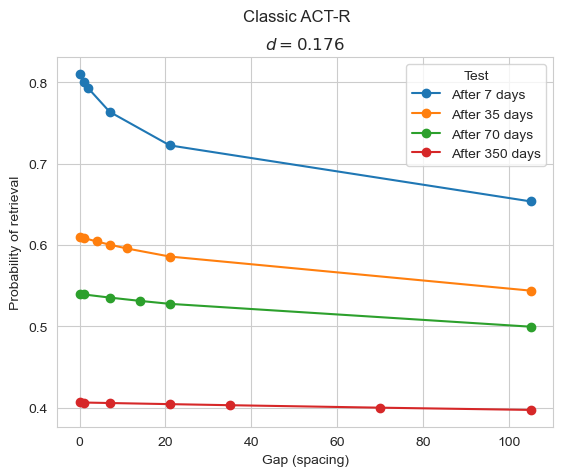

In [6]:

# Convert days into seconds
daysec = 24 # 60*60*24
d_default = .15

def actr(design, d=d_default):
    """Standard ACT-R simulation of a spacing effect design"""
    results = {}
    for ri in design.keys():
        ri_results = []
        gaps = design[ri]
        for gap in gaps:
            risec = ri * daysec
            gapsec = gap * daysec
            t = (ri + gap)*daysec
            t1 = 0
            t2 = gapsec
            odds1 = (t - t1)**-d
            odds2 = (t - t2)**-d 
            odds = odds1 + odds2
            prob = odds / (odds + 1)
            ri_results.append(odds)
        results[ri] = ri_results
    return results

def actrMSE(x):
    """Function for global optimization"""
    global design 
    d = x[0]
    results = actr(design, d)
    MSE = 0.0
    for ri in design.keys():
        predicted = np.array(results[ri])
        observed = np.array(cepeda.Accuracy[cepeda.RI == ri])
        MSE += np.sum((predicted - observed)**2)
    return MSE


bads = BADS(actrMSE, x0=[0.5], lower_bounds=[0], upper_bounds=[2], 
            plausible_lower_bounds=[0.1], plausible_upper_bounds=[1],
            options={'display':'off'})

actr_best = bads.optimize()
                            
results = actr(design, d = actr_best.x[0])

for ri in design.keys():
    x = design[ri]
    y = results[ri]
    plt.plot(x, y, "o-")
plt.legend(labels=["After %d days" % (x,) for x in design.keys()], title="Test")
plt.xlabel("Gap (spacing)")
plt.ylabel("Probability of retrieval")
plt.suptitle("Classic ACT-R")
plt.title("$d = %.3f$" % (actr_best.x[0]))
plt.show()

# Pavlik & Anderson's (2005) Spacing Model

To account for the spacing effect, Pavlik and Anderson (2005) introduced a modification to the decay term $d$. Specifically, they relaxed the constrained that $d$ is constant across all traces, and allow for every trace to have its own specific decay term $d_i$:

\begin{equation}
    A(m, t) = \sum_i (t - t_j)^{d_i}
\end{equation}

The trace-specific term $d_i$ depends on the current value of the activation $A(m, t=t_i)$ at the moment in which the trace was created. Thus, when the $i$-th trace is created, it is given a decay rate $d_i$ calculated as follows:

\begin{equation}
    d_i = c~\textrm{e}^{A(m, t = t_i)} + \phi
\end{equation}


where  $A(m, t = t_i)$ represents the activation of $m$ at time $t_i$. The spacing effect is made possible by including the term $c~\textrm{e}^{A(m, t = t_i)}$ in the computation of the decay rate. When two traces are temporally close together, the corresponding memory's activation at the moment the second trace is encoded is higher, resulting in a larger value of $c~\textrm{e}^{B(m, t = t_i)}$ and, therefore, a larger decay rate for the second trace.

Note that, even when allowing for different traces to decay at different rates, decay is still determined by a single parameter, $\phi$.

The final, complete model is noteworthy for its reliability, having been used to successfully model a variety of memory results and having been used to successfully derive optimal schedules for learning practice. The rate of forgetting $\alpha$ has been also used as an idiographic (i.e., person-specific) parameter, with $\alpha$ remaining a stable and reliable trait within the same individual across sessions and materials, and to assess individual differences in real-life outcomes, such as a student’s success at answering test questions after studying.

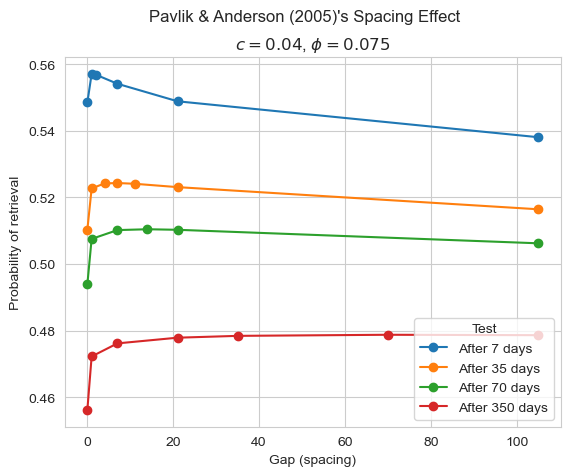

In [7]:
results = {}
d_default = 0.8
c_default = 0.01
daysec=24

def pavlik(design, d=d_default, c=c_default):
    results = {}
    for ri in design.keys():
        ri_results = []
        gaps = design[ri]
        for gap in gaps:
            risec = ri * daysec
            gapsec = gap * daysec
            t = (ri + gap)*daysec
            t1 = 0
            t2 = gapsec
            odds1 = (t - t1)**-d
            prob1 = odds1 / (odds1 + 1)
        
            d2 = c * t2**-d + d
        
            odds2 = (t - t2)**-d2 
            odds = odds1 + odds2
            prob = odds / (odds + 1)
            ri_results.append(prob)
        results[ri] = ri_results
    return results



def pavlik_mse(x):
    """Function for global optimization"""
    global design 
    c, d = x
    results = pavlik(design, c=c, d=d)
    MSE = 0.0
    for ri in design.keys():
        predicted = np.array(results[ri])
        observed = np.array(cepeda.Accuracy[cepeda.RI == ri])
        MSE += np.sum((predicted - observed)**2)
    return MSE
                        


bads = BADS(pavlik_mse, x0=[0.5, 0.5], lower_bounds=[0, 0], upper_bounds=[2, 2], 
            plausible_lower_bounds=[0.1, 0.01], plausible_upper_bounds=[1, 1],
            options={'display':'off'})

pavlik_best = bads.optimize()

results = pavlik(design, c = pavlik_best.x[0], d = pavlik_best.x[1])

for ri in design.keys():
    x = design[ri]
    y = results[ri]
    plt.plot(x, y, "o-")
plt.legend(labels=["After %d days" % (x,) for x in design.keys()],
           title="Test", loc="lower right")
plt.xlabel("Gap (spacing)")
plt.ylabel("Probability of retrieval")
plt.suptitle("Pavlik & Anderson (2005)'s Spacing Effect")
plt.title("$c = %.2f$, $\phi = %.3f$" % (pavlik_best.x[0], pavlik_best.x[1]))
plt.show()

## Best Fit Against Real Data

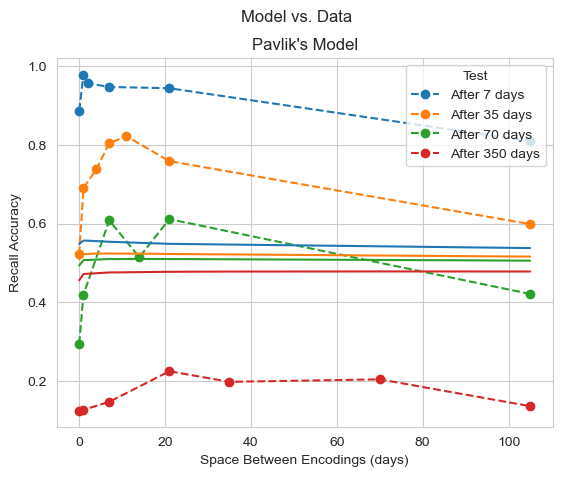

In [8]:
fig, ax = plt.subplots()
cepeda.groupby("RI").plot(x="Spacing", y="Accuracy", marker="o", ax=ax, linestyle="--")
ax.legend(["After %d days" % (x,) for x in [7, 35, 70, 350]],
          loc="upper right", title="Test")
ax.set_ylabel("Recall Accuracy")
ax.set_xlabel("Space Between Encodings (days)")
ax.set_title("Pavlik's Model")
fig.suptitle("Model vs. Data")

results = pavlik(design, c=pavlik_best.x[0], d=pavlik_best.x[1])
plt.gca().set_prop_cycle(None)
for ri in design.keys():
    x = design[ri]
    y = results[ri]
    ax.plot(x, y, "-")
plt.show()

# Alternative Model Based on Free Energy 

In this version, different traces share the same decay rate but have different _weights_:

$$A(m, t) = \log \sum_i w_i  (t - t_i)^{-d} $$

The $i$-th trace's weight $w_i$ is calculated as the _surprisal_ of memory _m_ at time $t_i$, that is:

$$ w_i = -\log P(m, t_i) $$

Because the activation of a memory is formally defined as its log odds, the probability of retrieving a memory $m$ is given by:

$$ P(m, t) = \frac{e^{A(m, t)}}{1 + e^{A(m,t)}} = \frac{1}{1 + e^{-A(m,t)}} $$

Thus, the weight can be expressed as:

$$ w_i = -\log \left( \frac{1}{1 + e^{-A(m,t)}} \right) = \log (1 + e^{-A(m, t)}) $$

Which is the softplus (continuos ReLU) function of $-A(m, t)$.

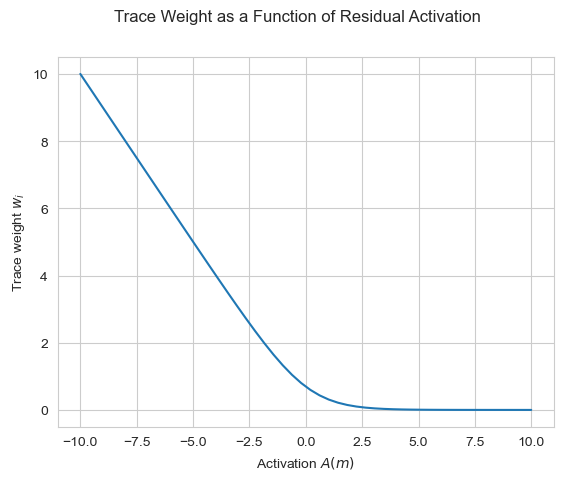

In [9]:
Am = np.linspace(-10, 10)
weights = np.log(1 + np.exp(-Am)) 

plt.plot(Am, weights)
plt.xlabel("Activation $A(m)$")
plt.ylabel("Trace weight $w_i$") 
plt.suptitle("Trace Weight as a Function of Residual Activation") 
plt.show()

This model can easily reproduce Cepeda's data

bads:TooCloseBounds: For each variable, hard and plausible bounds should not be too close. Moving plausible bounds.


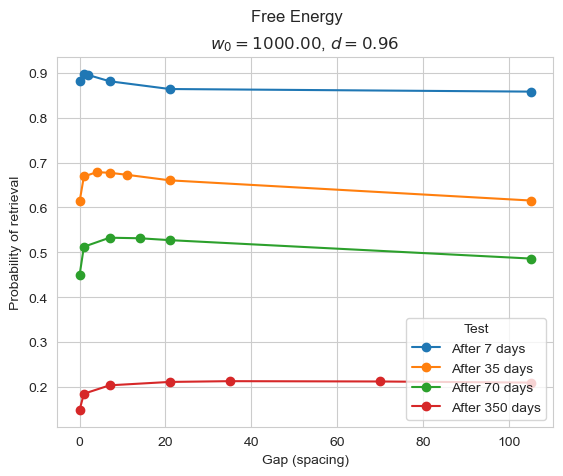

In [10]:
results = {}

d_default = 0.3
w_default = 10

daysec=24


def free_energy(design, d = d_default, w0 = w_default):
    results = {}
    for ri in design.keys():
        ri_results = []
        gaps = design[ri]
        for gap in gaps:
            risec = ri * daysec
            gapsec = gap * daysec
            t1 = 0
            t2 = gapsec
            t3 = risec + gapsec
        
            # Traces
        
            trace1 = (t3 - t1)**-d  # Trace 1 at time t
            trace2 = (t3 - t2)**-d  # Trace 2 at time t 
        
            # Weights
        
            w1 = w0 
        
            A_t2 = log((t2 - t1)**-d)
            w2 = log(1 + exp(-A_t2)) * (w0/10)
                
            A_t = log(w1 * trace1 + w2 * trace2)
            prob = exp(A_t) / (1 + exp(A_t))
            ri_results.append(prob)
        results[ri] = ri_results
    return results


def free_energy_mse(x):
    """Function for global optimization"""
    global design 
    d, w0 = x
    results = free_energy(design, w0=w0, d=d)
    MSE = 0.0
    for ri in design.keys():
        predicted = np.array(results[ri])
        observed = np.array(cepeda.Accuracy[cepeda.RI == ri])
        MSE += np.sum((predicted - observed)**2)
    return MSE



bads = BADS(free_energy_mse, x0=[0.5, 50], lower_bounds=[0, 0], upper_bounds=[2, 1000], 
            plausible_lower_bounds=[0.1, 0.01], plausible_upper_bounds=[1, 1000],
            options={'display':'off'})


free_energy_best = bads.optimize()

results = free_energy(design, d = free_energy_best.x[0], w0 = free_energy_best.x[1])


for ri in design.keys():
    x = design[ri]
    y = results[ri]
    plt.plot(x, y, "o-")
    
plt.legend(labels=["After %d days" % (x,) for x in design.keys()], title="Test", loc="lower right")
plt.xlabel("Gap (spacing)")
plt.ylabel("Probability of retrieval")
plt.suptitle("Free Energy")
plt.title("$w_0 = %.2f$, $d = %.2f$" % (free_energy_best.x[1], free_energy_best.x[0]))
plt.show()

## Best Fit Against Data

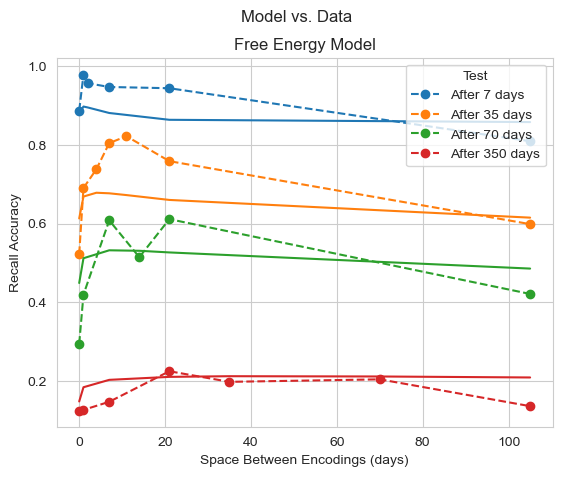

In [11]:
fig, ax = plt.subplots()
cepeda.groupby("RI").plot(x="Spacing", y="Accuracy", marker="o", ax=ax, linestyle="--")
ax.legend(["After %d days" % (x,) for x in [7, 35, 70, 350]],
          loc="upper right", title="Test")
ax.set_ylabel("Recall Accuracy")
ax.set_xlabel("Space Between Encodings (days)")
ax.set_title("Free Energy Model")
fig.suptitle("Model vs. Data")

results = free_energy(design, d=free_energy_best.x[0], w0=free_energy_best.x[1])

plt.gca().set_prop_cycle(None)
for ri in design.keys():
    x = design[ri]
    y = results[ri]
    
    ax.plot(x, y, "-")
plt.show()

## Range

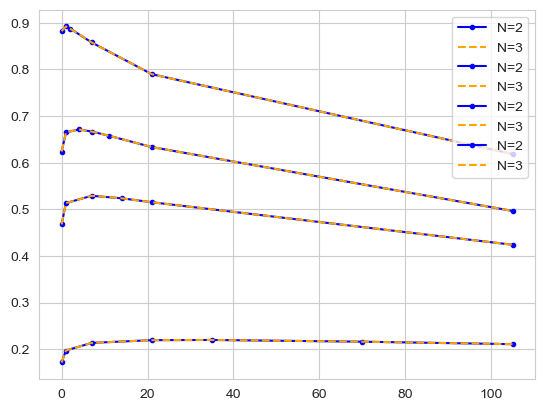

In [12]:
def free_energy_spliced(design, d = d_default, w0 = w_default, splice_factor = 0.5):
    results = {}
    for ri in design.keys():
        ri_results = []
        gaps = design[ri]
        for gap in gaps:
            risec = ri * daysec
            gapsec = gap * daysec
            t1 = 0
            t2 = gapsec * splice_factor
            t3 = gapsec
            t4 = risec + gapsec
        
            # Traces
        
            trace1 = (t4 - t1)**-d  # Trace 1 at time t
            trace2 = (t4 - t2)**-d  # Trace 2 at time t
            trace3 = (t4 - t3)**-d  # Trace 3 at time t
        
            # Weights
        
            w1 = w0 
        
            A_t2 = log((t2 - t1)**-d)
            w2 = log(1 + exp(-A_t2)) * (w0/10)

            A_t3 = log(w1 * trace1 + w2 * trace2)
            w3 = log(1 + exp(-A_t3)) * (w0/10)
                
            A_t = log(w1 * trace1 + w2 * trace2 + w3 * trace3)
            prob = exp(A_t) / (1 + exp(A_t))
            ri_results.append(prob)
        results[ri] = ri_results
    return results

results2 = free_energy(design, d = free_energy_best.x[0], w0 = free_energy_best.x[1])
results3 = free_energy_spliced(design, d = free_energy_best.x[0], w0 = free_energy_best.x[1], splice_factor=0.5)

for ri in design.keys():
    x = design[ri]
    y2 = results2[ri]
    y3 = results3[ri]
    plt.plot(x, y3, ".-", color="blue", label="N=2")
    plt.plot(x, y3, "--", color="orange", label="N=3")

plt.legend()
plt.show()

# Visual Comparison

Let's see a visual comparison of the models with three hypothetical traces

In [13]:
traces = [1, 25, 70]
time = np.linspace(0, 100, 201)
d = 0.3

## Standard ACT-R

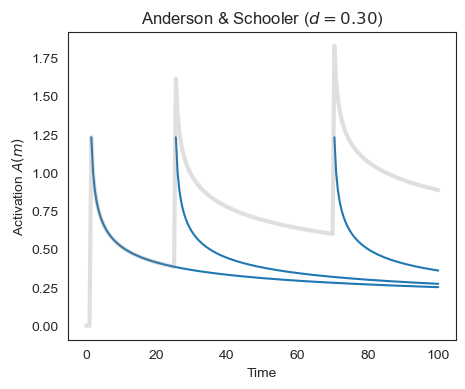

In [79]:
sns.set_style("white")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def trace_activation(time, creation, d = 0.3):
    if time <= creation:
        return np.NaN
    else:
        return  (time - creation) ** -d
        
fig, ax = plt.subplots()
fig.set_size_inches(5,4)

memory = np.zeros(time.size)

for t in traces:
    trace = [trace_activation(x, t) for x in time]
    ax.plot(time, trace, color=colors[0])
    memory += [x if x is not np.NaN else 0 for x in trace ] 
ax.plot(time, memory, linewidth=3, color="grey", alpha=0.25)
ax.set_xlabel("Time")
ax.set_ylabel("Activation $A(m)$")
ax.set_title("Anderson & Schooler ($d = %.2f$)" % (d,))
plt.show()

## Pavlik and Anderson (2005)

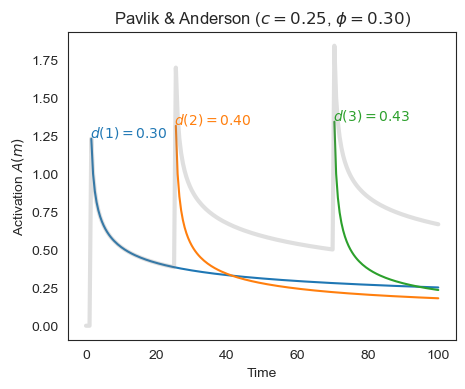

In [78]:
sns.set_style("white")
c = 0.25
default_d = 0.3
def trace_activation(time, creation, d = default_d):
    if time <= creation:
        return np.NaN
    else:
        return  (time - creation) ** -d
        
fig, ax = plt.subplots()
fig.set_size_inches(5,4)

memory = np.zeros(time.size)
for i, t in enumerate(traces):
    # find activation of existing memory
    closest_time = np.abs(time - t).argmin()
    activation = memory[closest_time]
    # find new decay
    dnew = c * activation + default_d
    trace = [trace_activation(x, t, d = dnew) for x in time]
    ax.plot(time, trace, color=colors[i])
    ax.text(t, 0.01 + np.max([x for x in trace if x is not np.nan]), 
            "$d(%d) = %.2f$" % (i+1, dnew),
           color=colors[i])
    memory += [x if x is not np.NaN else 0 for x in trace ] 

ax.plot(time, memory, linewidth=3, color="grey", alpha=0.25)
ax.set_xlabel("Time")
ax.set_ylabel("Activation $A(m)$")
ax.set_title("Pavlik & Anderson ($c = %.2f$, $\phi = %.2f$)" % (c, default_d))
plt.show()

## Free Energy

### Andrea's Model

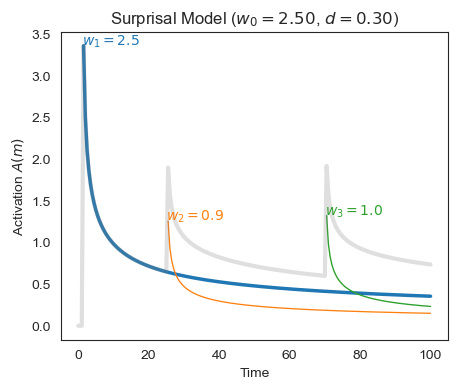

In [16]:
default_w = 2.5
default_d = 0.3

def trace_activation(time, creation, d = default_d):
    if time <= creation:
        return np.NaN
    else:
        return  (time - creation) ** -d
        
fig, ax = plt.subplots()
fig.set_size_inches(5,4)

memory = np.zeros(time.size)

for i, t in enumerate(traces):
    trace = [trace_activation(x, t, d = dnew) for x in time]
    
    # find activation of existing memory
    closest_time = np.abs(time - t).argmin()
    activation = memory[closest_time]
    if activation == 0:
        weight = default_w
    else:
        weight = np.log(1 + np.exp(-np.log(activation)))
    wtrace = weight * np.array(trace)
    ax.plot(time, wtrace, color=colors[i], linewidth=weight)
    ax.text(t, 0.01 + np.nanmax(wtrace), 
            "$w_%d = %.1f$" % (i+1, weight),
           color=colors[i])
    memory += weight * np.array([x if x is not np.nan else 0 for x in trace ])

ax.plot(time, memory, linewidth=3, color="grey", alpha=0.25)
ax.set_xlabel("Time")
ax.set_ylabel("Activation $A(m)$")
ax.set_title("Surprisal Model ($w_0 = %.2f$, $d = %.2f$)" % (default_w, default_d))
plt.show()


### Christian's Model

In Christian's approach, the model explicitly stabilizes activation by assigning the $N$-th trace a weight $w_N$ such that, after a specific amount of time $\Delta t$, the activation of the memory is kept at a constant value $K$:

$
w_N : A(m, t + \Delta t) = \log \sum_i^N w_i (t + \Delta t - t_i)^{-d} = K
$

#### Lisp 
The Lisp Original code was

```
(defun n-references (n isi ri &key (decay 0.5) (delta 1.0))
  "Returns weights for n evenly spaced references. Ignore RI."
  (declare (ignore ri))
  (let* ((now 0.0) ;;; initial time starts at 0
         (references (list (list now 1.0))) ;;; initial reference is time 0 and 1 full reference
         (baseline (exp (activation references :time (+ now delta) :decay decay)))) ;;; the exp cancels the log of activation so for delta=1 this is e^log(1)=1
    (dotimes (i (1- n))
      (incf now isi)
      (let* ((current (exp (activation references :time (+ now delta) :decay decay))) ;;; exponential of the current terms at time t+delta in the future
             (weight (/ (- baseline current) baseline))) ;;; current + weight * baseline = baseline with the trick that each new term is the same as the baseline
        (push (list now weight) references)))
    references))
```

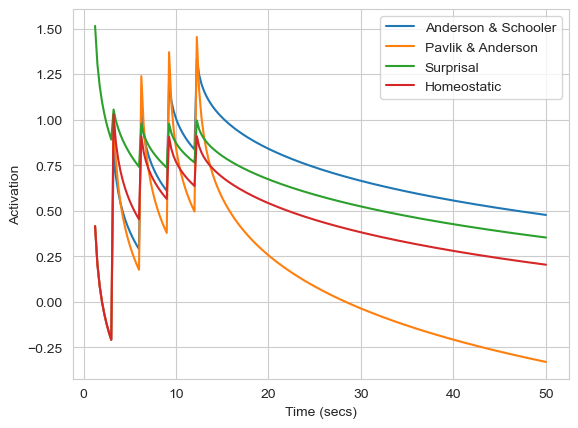

[0.3,
 0.5030630990890589,
 0.5981111305590197,
 0.6650642393145987,
 0.7105474482793981]

In [104]:
sns.set_style("whitegrid")

class Memory:
    """An ACT-R Memory"""
    def __init__(self, d=0.3):
        self.d = d
        self.traces = []

    def add_trace(self, trace):
        """Adds a trace"""
        self.traces.append(trace)

    def activation(self, time):
        """Returns the activation of the memory at time t"""
        d = self.d
        odds = 0.0
        for trace in self.traces:
            if trace < time:
                t = time - trace
                odds += t**-d
        return np.log(odds)

class PAMemory(Memory):
    """A Memory with Pavlik & Anderson's equation"""
    def __init__(self, d=0.3, c=0.25):
        super().__init__(d)
        self.c = c
        self.decays = []
        
    def add_trace(self, trace):
        d = self.d
        c = self.c
        if len(self.traces) == 0:
            self.decays.append(d)
        else:
            A  = self.activation(trace)
            new_d = c * np.exp(A) + d
            self.decays.append(new_d)
        self.traces.append(trace)

    def activation(self, time):
        """Returns the activation of the memory at time t"""
        odds = 0.0
        for trace, decay in zip(self.traces, self.decays):
            if trace < time:
                t = time - trace
                odds += t**-decay
        return np.log(odds)

class WeightedMemory(Memory):
    """A weighted memory"""
    def __init__(self, d=0.3):
        super().__init__(d)
        self.weights = []

    def add_trace(self, trace):
        """Adds a trace"""
        w = self.compute_weight(trace)
        super().add_trace(trace)
        self.weights += [w]
    
    def compute_weight(self, trace):
        return 1

    def activation(self, time):
        """Returns activation at time t"""
        d = self.d
        odds = 0.0
        for w, trace in zip(self.weights, self.traces):
            if trace < time:
                t = time - trace
                odds += w * t**-d
        return np.log(odds)

class SurprisalMemory(WeightedMemory):
    """An FEP memory with surprisal weights"""
    def __init__(self, d=0.3, w1=20):
        super().__init__(d)
        self.w1 = w1

    def compute_weight(self, trace):
        """Computes weights based on surprisal"""
        w = 0
        if len(self.traces) == 0:
            w = self.w1
        else:
            A = self.activation(trace)
            w = np.log(1 + np.exp(-A))
        return w


class HomestaticMemory(WeightedMemory):
    """A homestatic memory"""
    def __init__(self, d=0.3, w1=1, delta=1, k=0):
        super().__init__(d)
        self.w1 = 1
        self.k = k
        self.delta = delta
        self.traces = []
        self.weights = []

    def compute_weight(self, trace):
        """Computes weights based on surprisal"""
        w = 0
        if len(self.traces) == 0:
            w = self.w1
        else:
            dt = self.delta
            K = self.k
            A = self.activation(trace + dt)
            w = np.exp(K) - A
        return w

    
m = Memory()
pam = PAMemory(c=0.25)
sm = SurprisalMemory(w1=3)
hm = HomestaticMemory(w1=1, delta = 1, k=0)
for tr in [1, 3, 6, 9, 12]:
    m.add_trace(tr)
    pam.add_trace(tr)
    sm.add_trace(tr)
    hm.add_trace(tr)
    
time = np.linspace(0, 50, 201)
actr = [m.activation(t) for t in time]
pvlk = [pam.activation(t) for t in time]
srpr = [sm.activation(t) for t in time]
hmstc = [hm.activation(t) for t in time]
plt.plot(time, actr, label="Anderson & Schooler")
plt.plot(time, pvlk, label="Pavlik & Anderson")
plt.plot(time, srpr, label="Surprisal")
plt.plot(time, hmstc, label="Homeostatic")
plt.legend()
plt.xlabel("Time (secs)")
plt.ylabel("Activation")
plt.show()

pam.decays

In [17]:
lebiere_activation(10, [], 0.3)

-inf

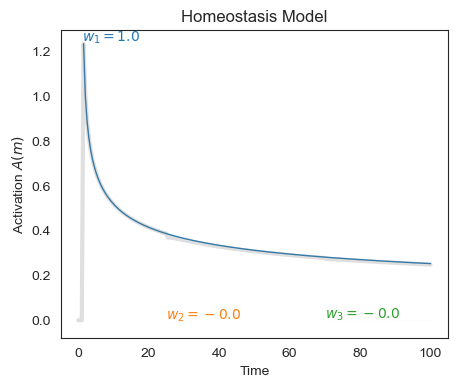

In [104]:
fig, ax = plt.subplots()
fig.set_size_inches(5,4)

traces = [1, 25, 70]
time = np.linspace(0, 100, 201)
d = 0.3
delta = 1
memory = np.zeros(time.size)

weights_so_far = []
traces_so_far = []

for i, t in enumerate(traces):
    # find activation of existing memory
    trace = [trace_activation(x, t, d) for x in time]
    
    if len(traces_so_far) > 0:
        current = lebiere_activation(t, traces = zip(traces_so_far, weights_so_far), d=d)
        future = lebiere_activation(t + delta, traces = zip(traces_so_far, weights_so_far), d=d)
        weight = (current - future) / current
    else:
        weight = 1
    #print(weight)
    wtrace = weight * np.array(trace)
    
    ax.plot(time, wtrace, color=colors[i], linewidth=weight)
    ax.text(t, 0.01 + np.nanmax(wtrace), 
            "$w_%d = %.1f$" % (i+1, weight),
           color=colors[i])
    memory += weight * np.array([x if x is not np.nan else 0 for x in trace ])

    traces_so_far.append(t)
    weights_so_far.append(weight)

ax.plot(time, memory, linewidth=3, color="grey", alpha=0.25)
ax.set_xlabel("Time")
ax.set_ylabel("Activation $A(m)$")
ax.set_title("Homeostasis Model")
plt.show()

In [90]:
k = [1, 2, 3]
k.append(4)
k

[1, 2, 3, 4]

# Model Comparison

## Long-term delay

One of the advantages of the FE model is that it predicts much less decay over time.

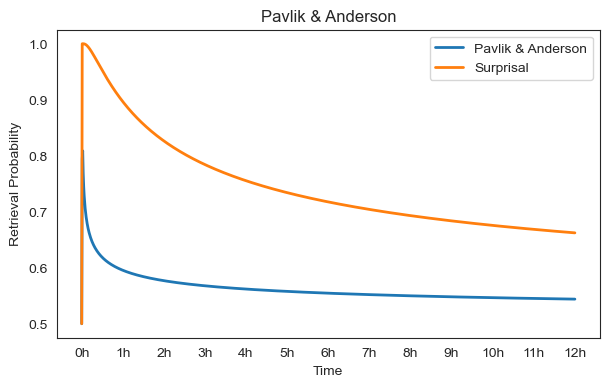

In [107]:
default_w = 25
default_d = 0.3
d = 0.3
noise=0.5
c = 0.25
threshold = -0

traces = [1, 10, 50]
time = np.linspace(0, 60*60*12, 1000)
sns.set_style("white")

default_d = 0.3
def trace_activation(time, creation, d = default_d):
    if time <= creation:
        return np.NaN
    else:
        return  (time - creation) ** -d
        
fig, ax = plt.subplots()
fig.set_size_inches(7,4)

memory = np.zeros(time.size)
for i, t in enumerate(traces):
    # find activation of existing memory
    closest_time = np.abs(time - t).argmin()
    activation = memory[closest_time]
    # find new decay
    dnew = c * activation + default_d
    trace = [trace_activation(x, t, d = dnew) for x in time]
    #ax.plot(time, trace, color=colors[i], linewidth=0.5)
    memory += [x if x is not np.NaN else 0 for x in trace ] 

ax.plot(time, [1 / (1 + np.exp(-x/noise + threshold)) for x in memory], linewidth=2, label="Pavlik & Anderson")
ax.set_xlabel("Time")
ax.set_ylabel("Retrieval Probability")
ax.set_title("Pavlik & Anderson")

memory = np.zeros(time.size)
for i, t in enumerate(traces):
    trace = [trace_activation(x, t, d = dnew) for x in time]
    
    # find activation of existing memory
    closest_time = np.abs(time - t).argmin()
    activation = memory[closest_time]
    if activation == 0:
        weight = default_w
    else:
        weight = np.log(1 + np.exp(-np.log(activation)))
    wtrace = weight * np.array(trace)
    #ax.plot(time, wtrace, color=colors[i], linewidth=weight)
    memory += weight * np.array([x if x is not np.nan else 0 for x in trace ])

ax.plot(time, [1 / (1 + np.exp(-x/noise + threshold)) for x in memory], linewidth=2, label="Surprisal")
ax.set_xticks([3600*x for x in range(0,13)],
                   ["%dh" % (x,) for x in range(0, 13)])
plt.legend()
plt.show()

## Parameter Space Partitioning (PSP)

A simple way to examine the model is Parameter Space Partitioning (PSP). In this case, we compute how many discrete patterns are generated by the model across parameters.

The key in the spacing effect is that all patterns have a _quadratic_ form, i.e., there is a peak in the middle. This is in contrast to a monotonic descending pattern (where the peak is on the first data point) and the monotonic ascending pattern (where the peak is at the end).

So, we can code the different patterns as follows:

* 0 = All curves are quadratic (correct predictions)
* 1 = Some curves are quadratic
* 2 = No curve is quadratic

In [58]:
from scipy.signal import find_peaks    

seq1 = [1, 2, 3, 4]
seq2 = [4, 3, 2, 1]
seq3 = [1, 2, 3, 2, 1]
seq4 = [1, 2, 1, 2, 1]

def categorize(results):
    sequences = [x[1] for x in results.items()]
    peaks = [find_peaks(seq)[0] for seq in sequences]
    npeaks = [x.shape[0] for x in peaks]
    
    N = len([n for n in npeaks if n > 0])
    K = len(results.keys())
        
    if N == K:
        return 0
    elif N > 0:
        return 1
    else:
        return 2

### PSP For Free Energy

2.0


/var/folders/99/15zptlt56d7f2h8pxlt9k4000000gn/T/ipykernel_13293/2222059610.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + [str(round(x, 1)) for x in d_space[0::MARKERS]])
/var/folders/99/15zptlt56d7f2h8pxlt9k4000000gn/T/ipykernel_13293/2222059610.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + [str(round(x, 0)) for x in w_space[0::MARKERS]])


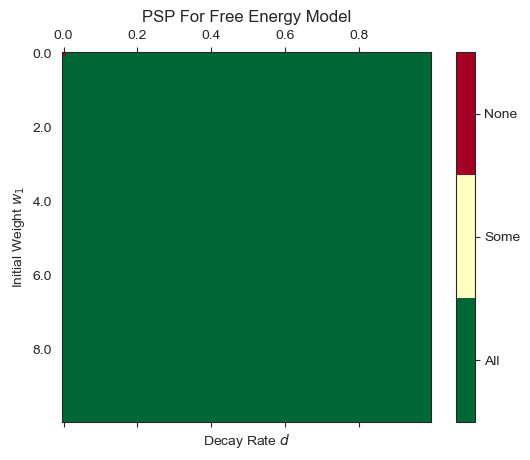

In [110]:
NPOINTS = 100
MARKERS = int(NPOINTS/5)

cmap = plt.get_cmap('RdYlGn_r', 3)    
w_space = np.linspace(1e-10, 10, NPOINTS) # Y axis
d_space = np.linspace(1e-10, 1, NPOINTS) # X Axis

S = np.zeros((len(w_space), len(d_space)))

for i, w0 in enumerate(w_space):
    for j, d in enumerate(d_space):
        res = free_energy(design, d=d, w0=w0)
        S[i, j] = categorize(res)

S[0,0]=2
print(np.sum(S))
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(S, interpolation='nearest', cmap=cmap)
fig.colorbar(cax, ticks=[1/3, 1, 5/3], format=FixedFormatter(["All", "Some", "None"]))
ax.xaxis.set_major_locator(MultipleLocator(MARKERS))
ax.yaxis.set_major_locator(MultipleLocator(MARKERS))
ax.set_xticklabels([''] + [str(round(x, 1)) for x in d_space[0::MARKERS]])
ax.set_yticklabels([''] + [str(round(x, 0)) for x in w_space[0::MARKERS]])
ax.set_ylabel("Initial Weight $w_1$")
ax.set_xlabel("Decay Rate $d$")
#ax.set_title("PSP For Free Energy Model, $w_1 \in [0, 10]$")
ax.set_title("PSP For Free Energy Model")
#plt.tight_layout()
plt.show()


### PSP For Pavlik's Model

/var/folders/99/15zptlt56d7f2h8pxlt9k4000000gn/T/ipykernel_9294/1871216692.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + [str(round(x, 1)) for x in d_space[0::MARKERS]])
/var/folders/99/15zptlt56d7f2h8pxlt9k4000000gn/T/ipykernel_9294/1871216692.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + [str(round(x, 0)) for x in c_space[0::MARKERS]])


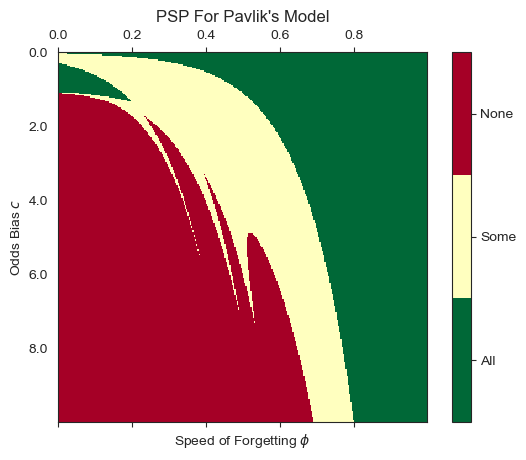

In [30]:
NPOINTS = 300
MARKERS = int(NPOINTS/5)

c_space = np.linspace(0, 10, NPOINTS)
d_space = np.linspace(1e-10, 1, NPOINTS)

S = np.zeros((len(c_space), len(d_space)))

for i, c in enumerate(c_space):
    for j, d in enumerate(d_space):
        res = pavlik(design, d=d, c=c)
        S[i, j] = categorize(res)
             
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(S, interpolation='nearest', cmap=cmap)
fig.colorbar(cax, ticks=[1/3, 1, 5/3], format=FixedFormatter(["All", "Some", "None"]))
ax.xaxis.set_major_locator(MultipleLocator(MARKERS))
ax.yaxis.set_major_locator(MultipleLocator(MARKERS))
ax.set_xticklabels([''] + [str(round(x, 1)) for x in d_space[0::MARKERS]])
ax.set_yticklabels([''] + [str(round(x, 0)) for x in c_space[0::MARKERS]])
ax.set_ylabel("Odds Bias $c$")
ax.set_xlabel("Speed of Forgetting $\phi$")
ax.set_title("PSP For Pavlik's Model")
plt.show()

## Size of spacing effect across parameters

In [19]:

def se_size(results):
    sequences = [x[1] for x in results.items()]
    size = 0.0
    for seq in sequences:
        peaks = find_peaks(seq)[0]    
        N = len(peaks)
        
        if N == 1:
            baseline = seq[0]
            peak = seq[peaks[0]]
            size += (peak - baseline)/baseline
    return size

se_size(results)

0.7410110308591967

/var/folders/99/15zptlt56d7f2h8pxlt9k4000000gn/T/ipykernel_9294/3587349704.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + [str(round(x, 1)) for x in d_space[0::40]])
/var/folders/99/15zptlt56d7f2h8pxlt9k4000000gn/T/ipykernel_9294/3587349704.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + [str(round(x, 0)) for x in w_space[0::40]])


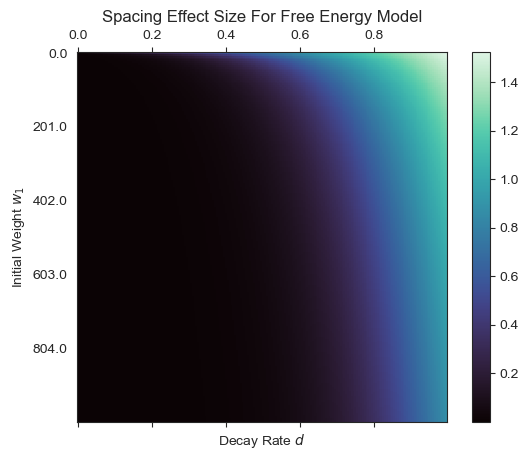

In [20]:
w_space = np.linspace(0.0001, 1000, 200) # Y axis
d_space = np.linspace(0.0001, 1.0001, 200) # X Axis

S = np.zeros((len(w_space), len(d_space)))

for i, w0 in enumerate(w_space):
    for j, d in enumerate(d_space):
        res = free_energy(design, d=d, w0=w0)
        S[i, j] = se_size(res)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(S, interpolation='nearest', cmap="mako")
fig.colorbar(cax)
ax.xaxis.set_major_locator(MultipleLocator(40))
ax.yaxis.set_major_locator(MultipleLocator(40))
ax.set_xticklabels([''] + [str(round(x, 1)) for x in d_space[0::40]])
ax.set_yticklabels([''] + [str(round(x, 0)) for x in w_space[0::40]])
ax.set_ylabel("Initial Weight $w_1$")
ax.set_xlabel("Decay Rate $d$")
ax.set_title("Spacing Effect Size For Free Energy Model")
plt.show()
plt.show()

/var/folders/99/15zptlt56d7f2h8pxlt9k4000000gn/T/ipykernel_9294/1221520481.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + [str(round(x, 1)) for x in d_space[0::20]])
/var/folders/99/15zptlt56d7f2h8pxlt9k4000000gn/T/ipykernel_9294/1221520481.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + [str(round(x, 1)) for x in c_space[0::20]])


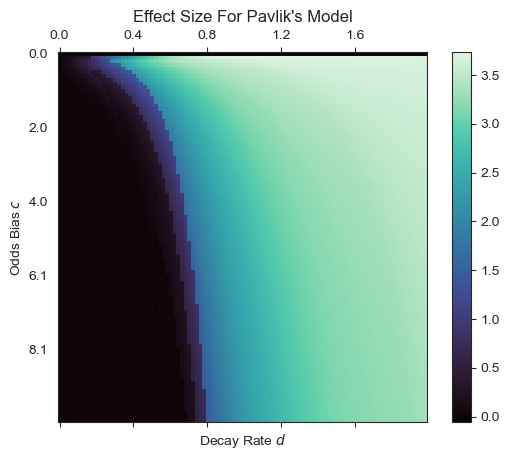

In [21]:
c_space = np.linspace(0, 10, 100)
d_space = np.linspace(0.0001, 2.0001, 100)

S = np.zeros((len(c_space), len(d_space)))

for i, c in enumerate(c_space):
    for j, d in enumerate(d_space):
        res = pavlik(design, d=d, c=c)
        S[i, j] = se_size(res)
             
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(S, interpolation='nearest', cmap="mako")
fig.colorbar(cax)
ax.xaxis.set_major_locator(MultipleLocator(20))
ax.yaxis.set_major_locator(MultipleLocator(20))
ax.set_xticklabels([''] + [str(round(x, 1)) for x in d_space[0::20]])
ax.set_yticklabels([''] + [str(round(x, 1)) for x in c_space[0::20]])
ax.set_ylabel("Odds Bias $c$")
ax.set_xlabel("Decay Rate $d$")
ax.set_title("Effect Size For Pavlik's Model")
plt.show()
plt.show()

# Neural Network Implementation

We can think of the hippocampus as a neural network

## A Hopfield network exhibits power law of forgetting  

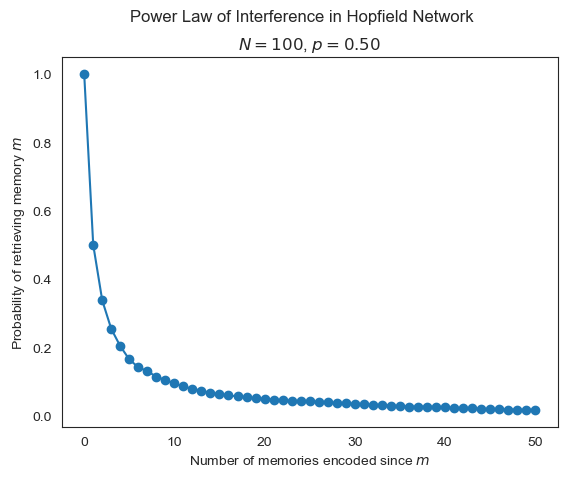

In [22]:
N = 100

P = 0.5

W = np.zeros((N, N))

def generate_memory(n=N, p=P):
    memory = stats.binom.rvs(1, P, size=N)
    memory[memory == 0] = -1
    return memory


def learn(memory):
    """Learn a pattern"""
    global W
    for i in range(N):
        for j in range(i+1, N):
            wij = memory[i] * memory[j]
            W[i,j] += 1/N * wij
            

def calculate_energy(memory):
    """Calculates the energy of the given memory"""
    H = 0
    for i in range(N):
        for j in range(N):
            H += W[i,j] * memory[i] * memory[j]
    return H


def calculate_probability(memory, memories, temperature=25):
    num = np.exp(calculate_energy(memory)/temperature)
    denom = np.sum([np.exp(calculate_energy(x)/temperature) for x in memories])
    return num/denom

memory = generate_memory()

learn(memory)
calculate_energy(memory)

memories = [memory]

results = [calculate_probability(memory, memories)]

weights = [np.sum(W)]

for n in range(50):
    new = generate_memory()
    memories.append(new)
    learn(new)
    results.append(calculate_probability(memory, memories))
    weights.append(np.sum(W))
    
plt.plot(results, "o-")
plt.xlabel("Number of memories encoded since $m$")
plt.ylabel("Probability of retrieving memory $m$")
plt.suptitle("Power Law of Interference in Hopfield Network" )
plt.title("$N = %d$, $p = %.2f$" % (N, P))
plt.show()

Also, synaptic weights tend to be stable

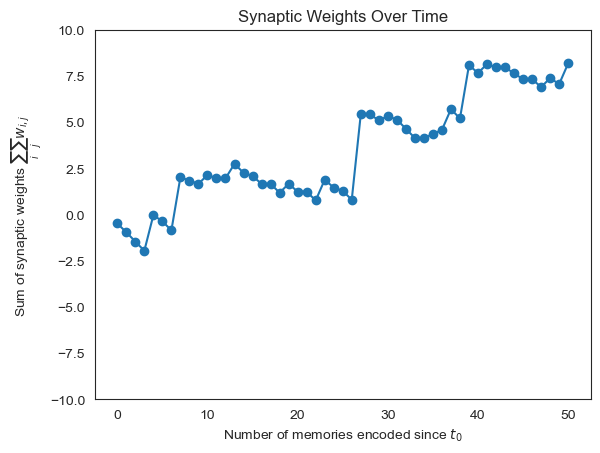

In [23]:
plt.plot(weights, "o-")
plt.ylim(-10, 10)
plt.xlabel("Number of memories encoded since $t_0$")
plt.ylabel("Sum of synaptic weights $\sum_i \sum_j w_{i,j}$")
plt.title("Synaptic Weights Over Time")
plt.show()

## Runaway activation due to retrievals

Similarly, a Hopfield model suffers from runaway activation due to retrievals

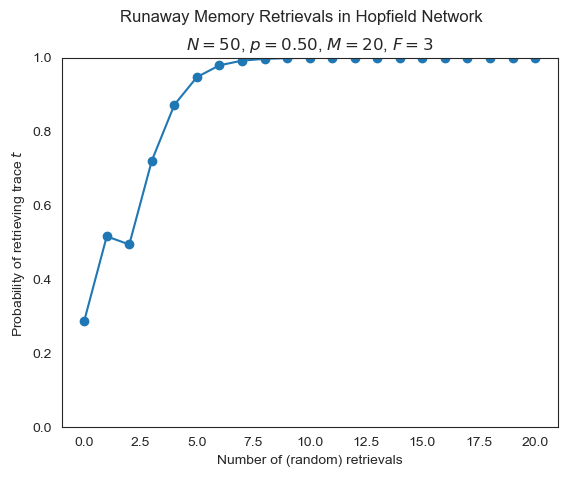

In [28]:
N = 50
P = 0.5
M = 20   # Number of memories
F = 3    # Frequencyt
W = np.zeros((N, N))

def retrieve(memories):
    probabilities = [calculate_probability(x, memories) for x in memories]
    return random.choices(memories, weights=probabilities, k=1)[0]

memory = generate_memory()
memories = [memory]


# Learn 19 other memories

for i in range(M-1):
    new = generate_memory()
    learn(new)
    memories.append(new)
    
# Over-retrieve the original memory

for i in range(3):
    learn(memory)

results = [calculate_probability(memory, memories)]

for n in range(20):
    retrieved = retrieve(memories)
    learn(retrieved)
    results.append(calculate_probability(memory, memories))

    
plt.plot(results, "o-")
plt.ylim(0, 1)
plt.xlabel("Number of (random) retrievals")
plt.ylabel("Probability of retrieving trace $t$")
plt.suptitle("Runaway Memory Retrievals in Hopfield Network")
plt.title("Runaway Memory Retrievals in Hopfield Network")
plt.title("$N = %d$, $p = %.2f$, $M = %d$, $F = %d$" % (N, P, M, F))
plt.show()

## Stabilizing effect of free energy

Text(0.5, 1.0, '$N = 50$, $p = 0.50$, $M$ = 20, $F$ = 3.')

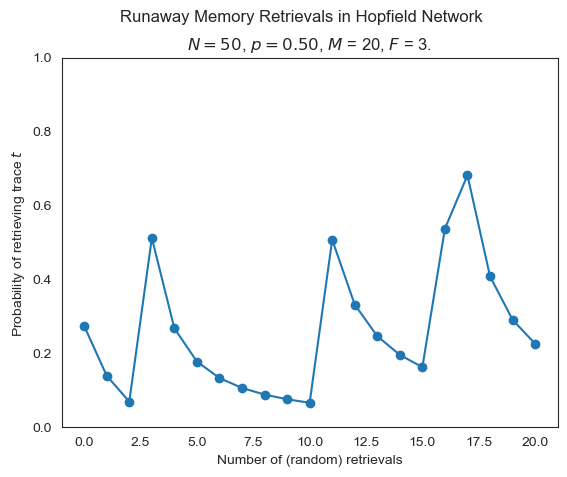

In [27]:
N = 50
P = 0.5
M = 20
F = 3
W = np.zeros((N, N))

def learn2(memory, memories):
    """Learn a pattern"""
    global W
    prob = calculate_probability(memory, memories)
    fnrg = -np.log(prob)
    for i in range(N):
        for j in range(i+1, N):
            wij = fnrg * memory[i] * memory[j]
            W[i,j] += 1/N * wij


memory = generate_memory()
memories = [memory]


# Learn 19 other memories

for i in range(M-1):
    new = generate_memory()
    learn(new)
    memories.append(new)
    
# Over-retrieve the original memory

for i in range(F):
    learn(memory)

results = [calculate_probability(memory, memories)]

for n in range(20):
    retrieved = retrieve(memories)
    learn2(retrieved, memories)
    results.append(calculate_probability(memory, memories))

    
plt.plot(results, "o-")
plt.xlabel("Number of (random) retrievals")
plt.ylabel("Probability of retrieving trace $t$")
plt.ylim(0,1)
plt.suptitle("Runaway Memory Retrievals in Hopfield Network")
plt.title("Runaway Memory Retrievals in Hopfield Network")
plt.title("$N = %d$, $p = %.2f$, $M$ = %d, $F$ = %d." % (N, P, M, F))
# Ol plt.show()

# Massed vs. Spaced (Eva)

AttributeError: module 'matplotlib.pyplot' has no attribute 'ax'

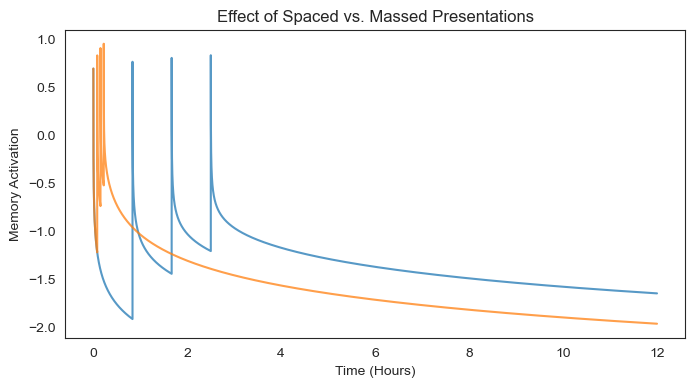

In [157]:
import matplotlib.pyplot as plt
import numpy as np

massed = [1, 60, 110, 160]
spaced = [1, 601, 1201, 1801]

sof = 0.3

fig, ax = plt.subplots()
fig.set_size_inches(8,4)

def trace_activation(time, creation, d = sof):
    """Activation of a single trace"""
    if time <= creation:
        return np.NaN
    else:
        return  (time - creation) ** -d
        

def activation(time, traces, c=0.25, sof=0.3):
    """P&A Activation for multiple traces"""
    memory = np.zeros(time.size)
    for i, t in enumerate(traces):
        # find activation of existing memory
        closest_time = np.abs(time - t).argmin()
        activation = memory[closest_time]
        
        # find new decay
        dnew = c * activation + sof
        trace = [trace_activation(x, t, d = dnew) for x in time]
        trace = [x if x is not np.NaN else 0 for x in trace ]
        trace = [x if x < 2 else 2 for x in trace]
        memory += trace
    return memory
        

time = np.linspace(0, 24*60*6, 300000)
plt.plot(time, np.log(activation(time, spaced)), label="Spaced", alpha=0.75)
plt.plot(time, np.log(activation(time, massed)), label="Massed", alpha=0.75)
plt.xticks([x * 24 * 60 for x in range(0, 7)],
           [x * 2 for x in range(0, 7)])
plt.xlabel("Time (Hours)")
plt.ylabel("Memory Activation")
plt.title("Effect of Spaced vs. Massed Presentations")
plt.ax
plt.legend()
plt.show()